This notebook checks the overlap of all cytosines (minimum x coverage) from several tools.
It also calculates some machine learning metrics using the methylation status of the cytosines.

# Imports

In [1]:
from pathlib import Path
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from matplotlib_venn import venn2
import seaborn as sns
from matplotlib import pyplot as plt

# Functions

In [2]:
min_cov = 4
min_nmod = 3

def read_bismark(file):
    """
    Reads output from Bismark Cytosine2coverage into 'bismark, chromosome_position, coverage, Nmods, context' format
    :param file: Output from Bismark Coverage2cytosine 
    :return: List with all cytosine positions that have a minimum coverage of x and their methylation status
    """
    bismark = []
    with open(file, 'r') as content:
        for line in content:
            line = line.split() # chrom pos strand Nmod Ncanonical Ccontext trincontext
            cov = int(line[3]) + int(line[4])
            if cov >= min_cov: # enough coverage
                if int(line[3]) >= min_nmod: # if Nmod > 3 status = True
                    status = 1
                else:
                    status = 0
                pos = f'{line[0]}_{int(line[1]) - 1}' # chromosome_position
                bismark.append([pos, cov, status, line[5]])
            continue # if cov < 4 skip the line
    return bismark

def read_dorado(file):
    """
    Reads output from Modkit into 'modkit, chromosome_position, coverage, Nmods, context' format
    :param file: Output from Modkit 
    :return: List with all cytosine positions that have a minimum coverage of x and their methylation status
    """
    dorado = []
    with open(file, 'r') as content:
        for line in content:
            line = line.split() # chrom s_pos e_pos type score strand s_pos e_pos color coverage fraction_modified Nmod Ncanonical Nother_mod Ndelete Nfail Ndiff Nnocall
            if int(line[9]) >= min_cov: # enough coverage
                if int(line[11]) >= min_nmod: # if Nmod > 3 status = True
                    status = 1
                else:
                    status = 0
                pos = f'{line[0]}_{line[1]}' # chromosome_position
                dorado.append([pos, line[9], status, "CG"]) # model only in CG context
            continue # if cov < 4 skip the line
    return dorado

def check_kmer(kmer):
    """
    Checks Kmer from DeepsignalPlant to determine cytosine context
    :param kmer: string from DeepsignalPlant
    :return: Context
    """
    if kmer[3] == 'G':
        context = 'CG'
    elif kmer[4] == 'G':
        context = 'CHG'
    else:
        context = 'CHH'
    return context

def read_dsp(file):
    """
    Reads output from Deepsignalplant call_freq into 'Super position, coverage, methylation status, context' format
    :param file: Output from deepsignalplant call_freq
    :return: List with all cytosine positions that have a minimum coverage of x and their methylation status
    """
    dsp = []
    with open(file, 'r') as content:
        for line in content:
            line = line.split() # chrom pos strand pos_in_strand prob_0_sum prob_1_sum Nmod Ncanonical coverage fraction_modified k_mer
            if int(line[8]) >= min_cov: # enough coverage
                if int(line[6]) >= min_nmod: # if Nmod > 3 status = True
                    status = 1
                else:
                    status = 0
                pos = f'{line[0]}_{line[1]}' # chromosome_position
                dsp.append([pos, line[8], status, check_kmer(line[10])]) 
            continue # if cov < 4 skip the line
    return dsp 

In [3]:
def intersection(a, b, verbose):
    """
    Check intersection of two lists
    :param a: List 1
    :param b: List 2
    :param verbose: Boolean to print output
    :return: Overlap, remainder a, remainder b
    """
    a = set(a)
    b = set(b)

    inter = a & b
    a_remainder = a - b
    b_remainder = b - a
    if verbose:
        print(f'length A: {len(a)}\nlength B: {len(b)}')
        print(f'Intersection: {len(inter)}\nA remainder: {len(a_remainder)}\nB remainder: {len(b_remainder)}')
        print(f'=====================')
    return inter, a_remainder, b_remainder

In [4]:
def calc_f1(a, b):
    """
    Calculates some machine learning metrics
    :param a: List with booleans that are considered the truth
    :param b: List with booleans
    :return: None
    """
    tn, fp, fn, tp = confusion_matrix(a, b).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    print(f'True_negative: {tn}\t False positive: {fp}\t False negative:{fn}\t True positive: {tp}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'f1: {f1}')
        
def calc_auc(a, b):
    """
    Calculate the ROC_AUC score
    :param a: List with booleans that are considered the truth
    :param b: List with booleans
    :return: None 
    """
    auc_roc = roc_auc_score(a, b)
    print(f'auc_roc: {auc_roc}')
    print(f'========================================')


In [5]:
def head(item):
    """
    Print first 10 lines of iterables
    :param item: Iterable object
    :return: None
    """
    for i in range(1,10):
        print(item[i])

# File paths

In [6]:
files = [Path(r'/home/bayraktar/PycharmProjects/basecalling_scripts/data/bismark_data/JR2.CX_report.txt'),      # Bismark output
         Path(r'/home/bayraktar/PycharmProjects/basecalling_scripts/data/report_nanopore/dorado_5mcg.bed'),     # Dorado output
         Path(r'/home/bayraktar/PycharmProjects/basecalling_scripts/data/report_nanopore/deepsignalplant.tsv'), # DeepsignalPlant output
         Path(r'/home/bayraktar/PycharmProjects/basecalling_scripts/data/report_nanopore/guppy_mods.bed')]      # Guppy output

# Read in the files

In [7]:
bismark = read_bismark(files[0])
# head(bismark)

dorado = read_dorado(files[1])
# head(dorado)

dsp = read_dsp(files[2])
# head(dsp)

guppy = read_dorado(files[3])

In [8]:
head(bismark)

['1_3183', 6, 0, 'CHH']
['1_3188', 6, 0, 'CHH']
['1_3189', 6, 0, 'CHG']
['1_3190', 6, 0, 'CG']
['1_3191', 7, 0, 'CG']
['1_3192', 7, 0, 'CHG']
['1_3193', 7, 0, 'CHH']
['1_3196', 7, 0, 'CHH']
['1_3197', 6, 0, 'CHH']


# Get the positions for intersection

In [9]:
# Row[0] = super position
# row[2] = methylation status of cytosine: 0 or 1
bismark_pos = {row[0]:row[2] for row in bismark}
dorado_pos = {row[0]:row[2] for row in dorado}
guppy_pos = {row[0]:row[2] for row in guppy}
dsp_pos = {row[0]:row[2] for row in dsp}

bismark_CG_pos = {row[0]:row[2] for row in bismark if row[3] == "CG"}
dsp_CG_pos = {row[0]:row[2] for row in dsp if row[3] == "CG"}


# Calculate the intersection

In [10]:
# Calculate the intersection between the tools regardless of cytosine methylation status

print(f'A: bismark_CG\nB: dorado')
bismark_dorado_CG, bismark_CG_remainder, dorado_bs_remainder = intersection(bismark_CG_pos.keys(), dorado_pos.keys(), True)

print(f'A: dorado\nB: DSP')
dorado_dsp_CG, dorado_dsp_remainder, dsp_cg_remainder = intersection(dorado_pos.keys(), dsp_CG_pos.keys(), True)

print(f'A: bismark\nB: DSP')
bismark_dsp, bismark_dsp_remainder, dsp_bismark_remainder = intersection(bismark_pos.keys(), dsp_pos.keys(), True)

print(f'A: Dorado\nB: Guppy')
dorado_guppy_CG, dorado_guppy_remainder, guppy_dorado_remainder = intersection(dorado_pos.keys(), guppy_pos.keys(), True)

print(f'A: DSP\nB: Guppy')
dsp_guppy_CG, dsp_guppy_remainder, guppy_dsp_remainder = intersection(dsp_CG_pos.keys(), guppy_pos.keys(), True)



A: bismark_CG
B: dorado
length A: 4904882
length B: 5055554
Intersection: 4903005
A remainder: 1877
B remainder: 152549
A: dorado
B: DSP
length A: 5055554
length B: 5057422
Intersection: 5055421
A remainder: 133
B remainder: 2001
A: bismark
B: DSP
length A: 18758324
length B: 19497234
Intersection: 18757174
A remainder: 1150
B remainder: 740060
A: Dorado
B: Guppy
length A: 5055554
length B: 5055730
Intersection: 5054454
A remainder: 1100
B remainder: 1276
A: DSP
B: Guppy
length A: 5057422
length B: 5055730
Intersection: 5055665
A remainder: 1757
B remainder: 65


Text(0.5, 1.0, 'Cytosine position overlap')

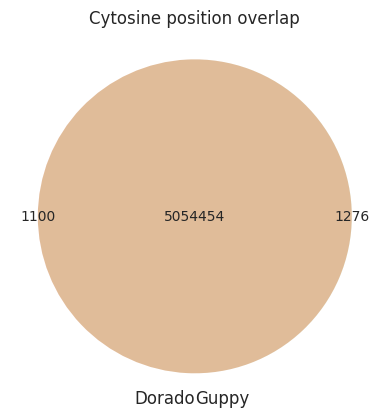

In [10]:
venn2([dorado_pos.keys(), guppy_pos.keys()], set_labels = ('Dorado', 'Guppy'))
plt.title('Cytosine position overlap')

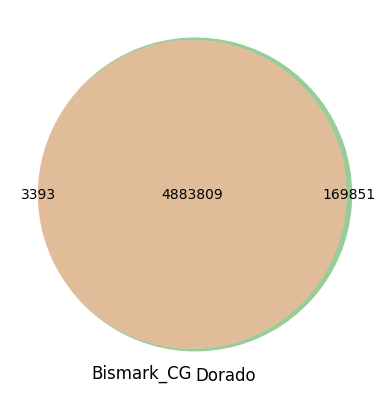

In [10]:
venn2([bismark_CG_pos.keys(), dorado_pos.keys()], set_labels = ('Bismark_CG', 'Dorado'))

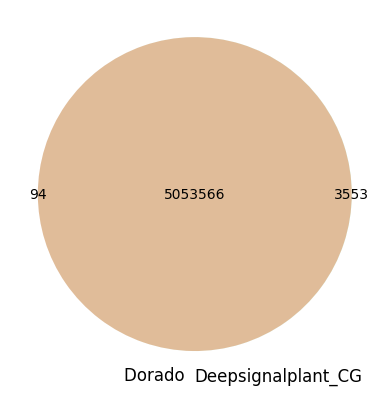

In [11]:
venn2([dorado_pos.keys(), dsp_CG_pos.keys()], set_labels = ('Dorado  ', 'Deepsignalplant_CG'))

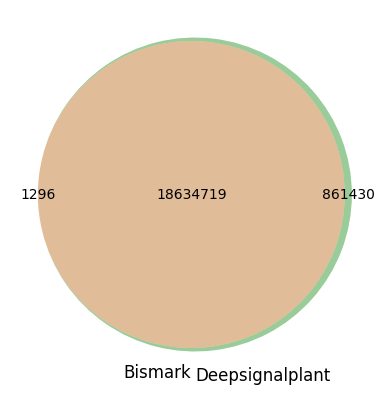

In [12]:
venn2([bismark_pos.keys(), dsp_pos.keys()], set_labels = ('Bismark', 'Deepsignalplant'))

# Calculate scores

Now we will extract the overlapping positions between the tools. The order in which we extract matters here. This way we can compare the status of the overlapping cytosines

In [11]:
dorado_bools = []
dsp_CG_bools = []
for pos in dorado_dsp_CG: # loops through the overlapping positions
    dorado_bools.append(dorado_pos[pos]) # extracts the methylation status of given position (0 or 1) and appends it to list in order
    dsp_CG_bools.append(dsp_CG_pos[pos])

bismark_bools = []
dsp_bools = []
for pos in bismark_dsp:
    bismark_bools.append(bismark_pos[pos])
    dsp_bools.append(dsp_pos[pos])

dorado_bs_bools = []    
bismark_CG_bools = []
for pos in bismark_dorado_CG:
    bismark_CG_bools.append(bismark_CG_pos[pos])
    dorado_bs_bools.append(dorado_pos[pos])


dorado_gup_bools = []
guppy_dor_bools = []
for pos in dorado_guppy_CG:
    dorado_gup_bools.append(dorado_pos[pos])
    guppy_dor_bools.append(guppy_pos[pos])
    
dsp_guppy_bools = []
guppy_dsp_bools = []
for pos in dsp_guppy_CG:
    dsp_guppy_bools.append(dsp_CG_pos[pos])
    guppy_dsp_bools.append(guppy_pos[pos])
    
print(len(dorado_bools))
print(len(dsp_CG_bools))

print(len(bismark_bools))
print(len(dsp_bools))

print(len(bismark_CG_bools))
print(len(dorado_bs_bools))

print(len(dorado_gup_bools))
print(len(guppy_dor_bools))

print(len(dsp_guppy_bools))
print(len(guppy_dsp_bools))

5055421
5055421
18757174
18757174
4903005
4903005
5054454
5054454
5055665
5055665


In [15]:
print(f'BISMARK Vs DSP')
calc_f1(bismark_bools, dsp_bools)
calc_auc(bismark_bools, dsp_bools)

print(f'BISMARK Vs Dorado')
calc_f1(bismark_CG_bools, dorado_bs_bools)
calc_auc(bismark_CG_bools, dorado_bs_bools)

print(f'DSP Vs Dorado')
calc_f1(dsp_CG_bools, dorado_bools)
calc_auc(dsp_CG_bools, dorado_bools)


print(f'Guppy Vs Dorado')
calc_f1(guppy_dor_bools, dorado_gup_bools)
calc_auc(guppy_dor_bools, dorado_gup_bools)

print(f'Dsp Vs Guppy')
calc_f1(dsp_guppy_bools, guppy_dsp_bools)
calc_auc(dsp_guppy_bools, guppy_dsp_bools)


BISMARK Vs DSP
True_negative: 18577104	 False positive: 54522	 False negative:2196	 True positive: 897
Precision: 0.01618578465869106
Recall: 0.29000969932104753
f1: 0.030660377358490563
auc_roc: 0.6435416923386668
BISMARK Vs Dorado
True_negative: 4870710	 False positive: 11328	 False negative:1653	 True positive: 118
Precision: 0.010309278350515464
Recall: 0.06662902315076229
f1: 0.017855791783309375
auc_roc: 0.5321543403518061
DSP Vs Dorado
True_negative: 5004570	 False positive: 9264	 False negative:34852	 True positive: 4880
Precision: 0.34502262443438914
Recall: 0.12282291352058794
f1: 0.18115673026950774
auc_roc: 0.5604876128516204
Guppy Vs Dorado
True_negative: 5028760	 False positive: 10199	 False negative:8930	 True positive: 3907
Precision: 0.27697433716149156
Recall: 0.30435459998442005
f1: 0.29001967115762906
auc_roc: 0.6511652854074516
Dsp Vs Guppy
True_negative: 5006238	 False positive: 7817	 False negative:34755	 True positive: 5069
Precision: 0.39337265249107556
Recall:

<Axes: title={'center': 'Bismark vs. DeepsignalPlant'}, xlabel='DeepsignalPlant 5mC', ylabel='Bismark 5mC'>

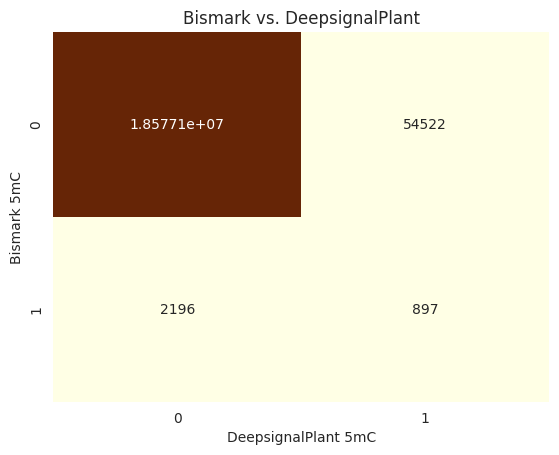

In [24]:
a = confusion_matrix(bismark_bools, dsp_bools)
ax = sns.heatmap(a, annot=True, fmt='g', cbar=False, cmap=sns.color_palette("YlOrBr", as_cmap=True))
ax.set(ylabel='Bismark 5mC', xlabel='DeepsignalPlant 5mC')
ax.set_title('Bismark vs. DeepsignalPlant')
ax

<Axes: title={'center': 'Bismark vs. Dorado'}, xlabel='Dorado 5mCG', ylabel='Bismark 5mCG'>

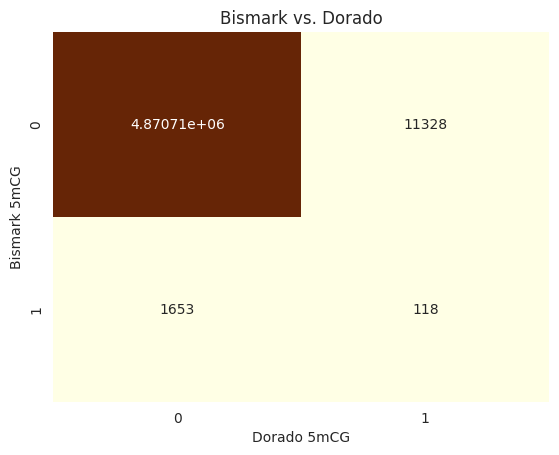

In [25]:
a = confusion_matrix(bismark_CG_bools, dorado_bs_bools)
ax = sns.heatmap(a, annot=True, fmt='g', cbar=False, cmap=sns.color_palette("YlOrBr", as_cmap=True) )
ax.set(ylabel='Bismark 5mCG', xlabel='Dorado 5mCG')
ax.set_title('Bismark vs. Dorado')
ax

<Axes: title={'center': 'DeepsignalPlant vs. Dorado'}, xlabel='Dorado 5mCG', ylabel='DeepsignalPlant 5mCG'>

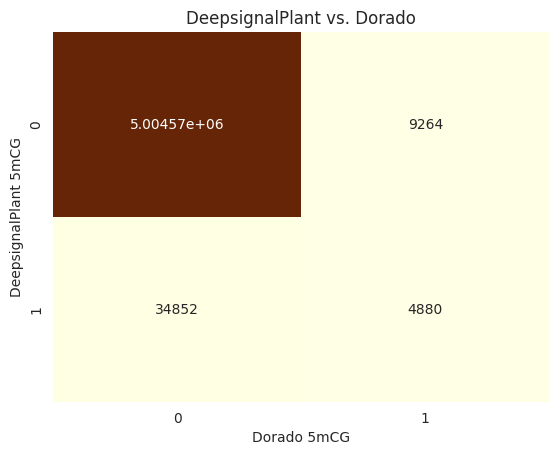

In [11]:
a = confusion_matrix(dsp_CG_bools, dorado_bools)
ax = sns.heatmap(a, annot=True, fmt='g', cbar=False, cmap=sns.color_palette("YlOrBr", as_cmap=True) )
ax.set(ylabel='DeepsignalPlant 5mCG', xlabel='Dorado 5mCG')
ax.set_title('DeepsignalPlant vs. Dorado')
ax

<Axes: title={'center': 'Guppy vs. Dorado'}, xlabel='Dorado 5mCG', ylabel='Guppy 5mCG'>

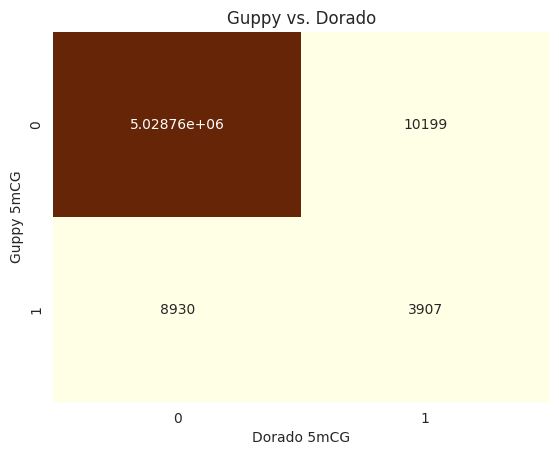

In [26]:
a = confusion_matrix(guppy_dor_bools, dorado_gup_bools)
ax = sns.heatmap(a, annot=True, fmt='g', cbar=False ,cmap=sns.color_palette("YlOrBr", as_cmap=True))
ax.set(ylabel='Guppy 5mCG', xlabel='Dorado 5mCG')
ax.set_title('Guppy vs. Dorado')
ax

<Axes: title={'center': 'DeepsignalPlant vs. Guppy'}, xlabel='Guppy 5mCG', ylabel='DeepsignalPlant 5mCG'>

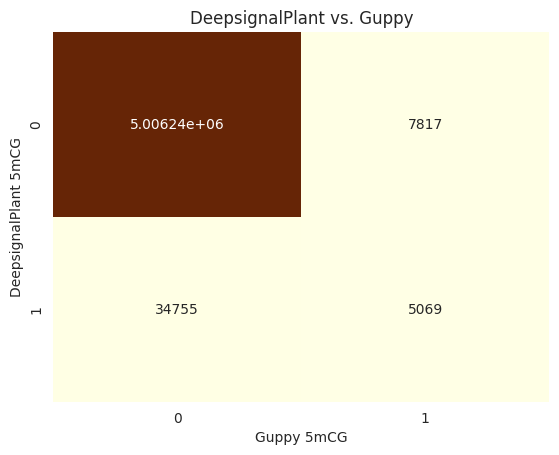

In [27]:
a = confusion_matrix(dsp_guppy_bools, guppy_dsp_bools )
ax = sns.heatmap(a, annot=True, fmt='g', cbar=False ,cmap=sns.color_palette("YlOrBr", as_cmap=True))
ax.set(ylabel='DeepsignalPlant 5mCG', xlabel='Guppy 5mCG')
ax.set_title('DeepsignalPlant vs. Guppy')
ax